In [54]:
import functools
import seaborn as sns
sns.set_context('paper')

### Load Database

In [95]:
%run AH_DATABASE.ipynb


Usage: 
  db = DB(server)          --> initializes database
  db.get_df(item)          --> returns dataframe, prices divided by 100 so copper in decimal 
  db.get_name(item)        --> returns name of item  
  db.get_last_record(item) --> returns most recent record
  db.plot(item, y)         --> plots column over time



In [96]:
db = DB('earthfury-alliance')

### Flipping Analysis
Assume you purchase at a given percentile price 'buy_pctile' of an item and flip it for a 15% profit.  By examining how minBidprice fluctuates over time, determine how many times you could perform this flip 'num_flips'.  Calulate numFlips for values of P from 1 to 100.  Determine the optimal 'buy_pctile' that maximizes num_flips and look up the corresponding minBidPrice.

In [71]:
def num_flips_at_pctile(item, buy_pctile, profit=.15):
    df = db.get_df(item)
    count = 0
    buysell = 'buy'    
    
    for pct, val in df[['minBuyoutPctile','minBuyout']].to_numpy(): #apparently way faster than df.iterrows()
        # buy conditions
        if buysell=='buy' and pct < buy_pctile:
            price   = val
            buysell = 'sell'        
        # sell conditions
        if buysell=='sell' and val > price*(1+profit):
            count += 1
            buysell = 'buy'    
    return count

def num_flips_over_all_pctiles(item):
    return [ (i/100, num_flips_at_pctile(item,i/100)) for i in range(0,100)]

def get_minBuyout_at_pctile(item, pctile):
    arr = db.get_df(item)['minBuyout'].to_list()
    return np.percentile(arr, pctile*100)

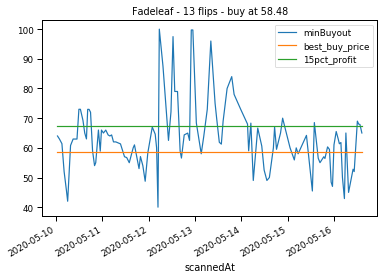

In [88]:
def find_optimal_flip(item, show_plot=False):
    flip_profile =  num_flips_over_all_pctiles(item)
    best_pctile, best_num_flips = max(flip_profile, key=lambda x:x[1])
    best_buy_price = get_minBuyout_at_pctile(item, best_pctile)
    
    if show_plot:
        df = db.get_df(item)
        df['best_buy_price'] = best_buy_price
        df['15pct_profit'] = best_buy_price * 1.15
        graph_title = f'{db.get_name(item)} - {best_num_flips} flips - buy at {round(best_buy_price,2)}'
        df.plot('scannedAt', ['minBuyout', 'best_buy_price', '15pct_profit'], title=graph_title)
    
    # return export ready data if not in plot mode
    else:
        return {
            'name'        : db.get_name(item),
            'item_id'     : item,
            'buy_price'   : int(100 * best_buy_price),         # scaling copper back into integer for export
            'min_price'   : int(100 * best_buy_price * 1.15),  # scaling copper back into integer for export
            'normal_price': int(100 * best_buy_price * 1.25),  # scaling copper back into integer for export
            'max_price'   : int(100 * best_buy_price * 1.5),   # scaling copper back into integer for export
            'num_flips'   : best_num_flips
        }

find_optimal_flip(3818, show_plot=True)        

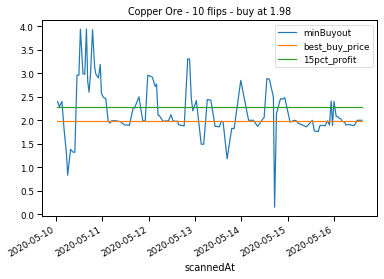

In [89]:
find_optimal_flip(2770, show_plot=True)

In [91]:
find_optimal_flip(2770, show_plot=False)

{'name': 'Copper Ore',
 'item_id': 2770,
 'buy_price': 198,
 'min_price': 227,
 'normal_price': 247,
 'max_price': 297,
 'num_flips': 10}

### Run All Materials

In [97]:
%run ITEMS.ipynb


loaded
  herbs    : 30 items
  cloth    : 12 items
  mining   : 27 items
  enchant  : 24 items
  skinning : 11 items
  ALL      : 104 items



In [77]:
print(herbs)

[8153, 8836, 13468, 13466, 13465, 8845, 8831, 3355, 2453, 3369, 2447, 765, 3356, 3358, 4625, 2450, 3821, 3818, 8846, 8838, 3820, 3819, 8839, 2452, 2449, 785, 13467, 3357, 13463, 13464]


In [92]:
results = []
print(f'running for {len(ALL)} items')
for i in range(0, len(ALL)):
    item = ALL[i]
 
    # catch no data errors with try/except
    try:
        results.append(find_optimal_flip(item))
    except: 
        print(f'! ERROR - {item}, {db.get_name(item)}')
        
    # print progress
    if i%10 ==0:
        print(f' ...{i} done')   
print('COMPLETE')
    

running for 104 items
 ...0 done
 ...10 done
 ...20 done
 ...30 done
 ...40 done
 ...50 done
 ...60 done
! ERROR - 17771, Elementium Bar
! ERROR - 3861, Blacksteel Bar
 ...70 done
 ...80 done
 ...90 done
! ERROR - 20725, Nexus Crystal
 ...100 done
COMPLETE


In [93]:
df = pd.DataFrame(results)
df.head()

,name,item_id,buy_price,min_price,normal_price,max_price,num_flips
0,Wildvine,8153,10000,11500,12500,15000,10
1,Arthas' Tears,8836,452,520,565,678,9
2,Black Lotus,13468,1630200,1874729,2037750,2445300,1
3,Plaguebloom,13466,19200,22080,24000,28800,10
4,Mountain Silversage,13465,12395,14254,15493,18592,12


### Export

In [98]:
%run EXPORT.ipynb

 
Usage:
  EXPORT(dataframe)       --> expects df with specific column names
                                  name
                                  item_id
                                  buy_price
                                  min_price
                                  normal_price
                                  max_price
  example_export_input()  --> shows expected data schema
  example_export_output() --> shows output of example data



In [94]:
choice = df.query('num_flips >=10 and buy_price>500')
choice

,name,item_id,buy_price,min_price,normal_price,max_price,num_flips
0,Wildvine,8153,10000,11500,12500,15000,10
3,Plaguebloom,13466,19200,22080,24000,28800,10
4,Mountain Silversage,13465,12395,14254,15493,18592,12
5,Ghost Mushroom,8845,11677,13429,14597,17516,12
6,Purple Lotus,8831,733,843,916,1100,12
9,Grave Moss,3369,4354,5007,5443,6531,13
14,Firebloom,4625,2800,3219,3500,4200,14
17,Fadeleaf,3818,5847,6725,7309,8771,13
19,Sungrass,8838,2801,3221,3502,4202,16
20,Stranglekelp,3820,2000,2300,2500,3000,16


In [22]:
EXPORT(choice)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^SPlaguebloom^T^SaboveMax^SmaxPrice^SnormalPrice^S24001^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N4^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S28801^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S22080^SkeepQtySources^T^t^Sblacklist^S^t^SMountain Silversage^T^SaboveMax^SmaxPrice^SnormalPrice^S15482^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N4^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S18579^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S14244^SkeepQtySources^T^t^Sblacklist^S^t^SGhost Mushroom^T^SaboveMax^SmaxPrice^SnormalPrice^S14475^Sduration^N3^Sm